# A Gentle Introduction to Exponential Smoothing with NumPyro

## Prepare Notebook

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import pandas as pd
from jax import random
from jaxlib.xla_extension import ArrayImpl
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS, Predictive

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Read Data

[Text(0.5, 0, 'time'), Text(0, 0.5, 'y'), Text(0.5, 1.0, 'Time Series Data')]

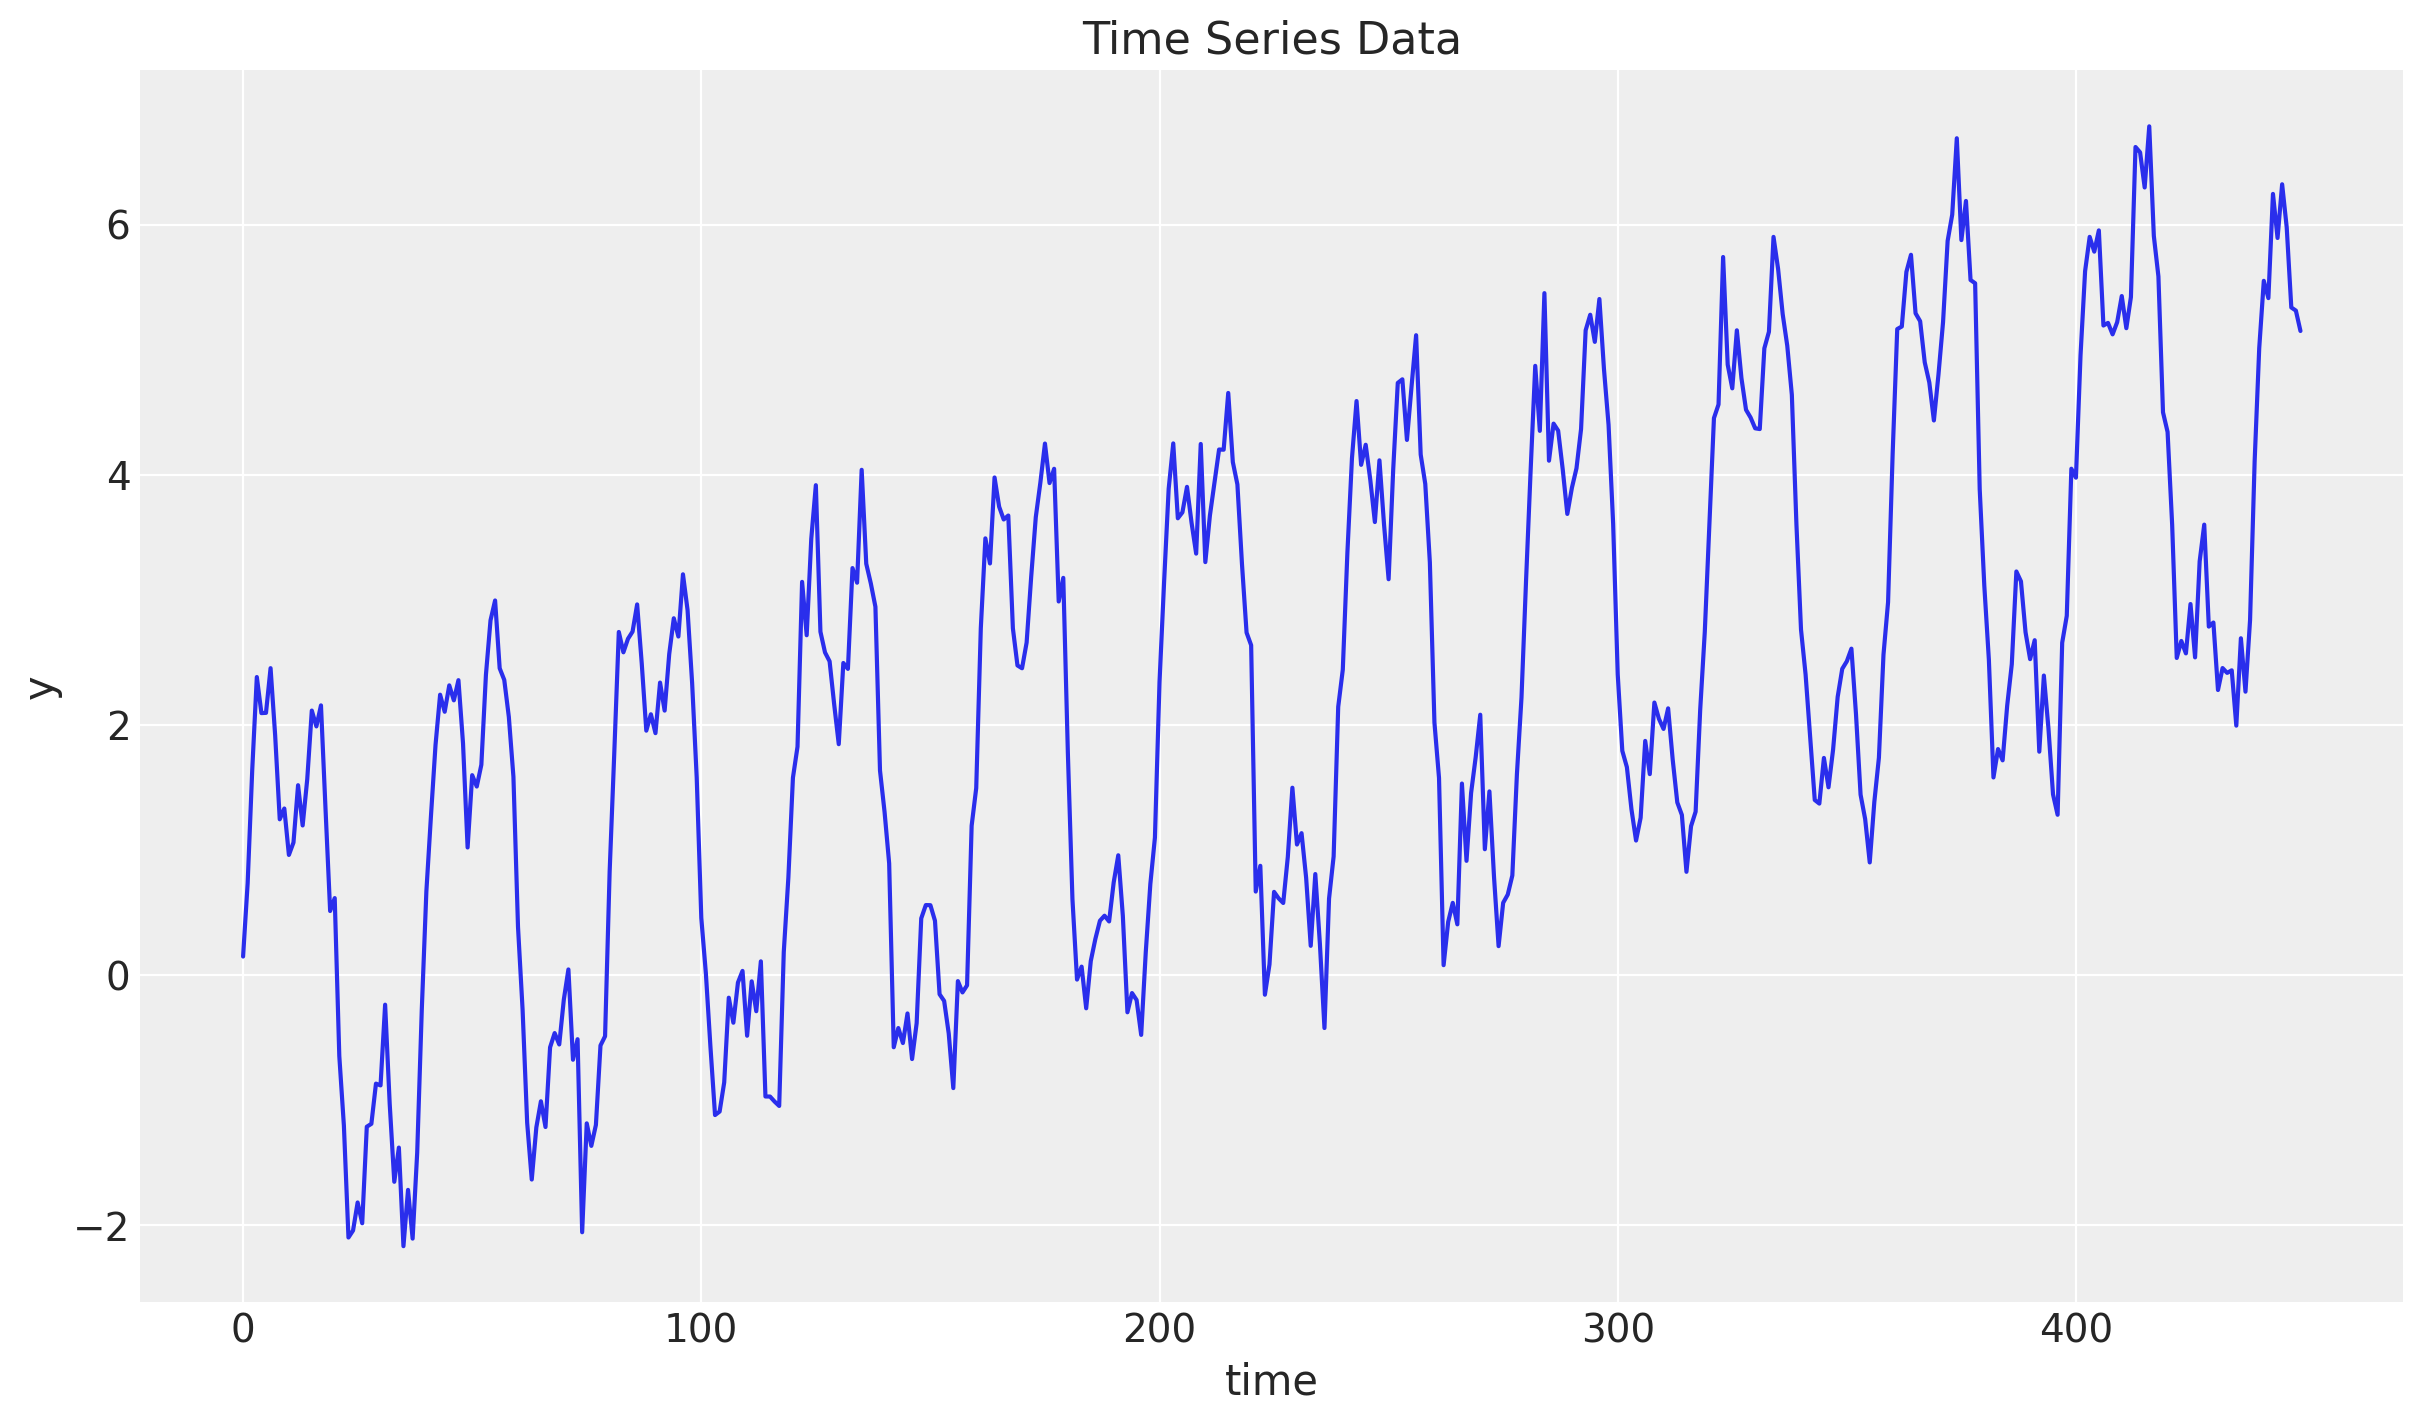

In [2]:
y = jnp.array(
    pd.read_csv("../data/simple_ts_data.csv", usecols=["y"]).to_numpy().flatten()
)

fig, ax = plt.subplots()
ax.plot(y)
ax.set(xlabel="time", ylabel="y", title="Time Series Data")

## Train - Test Split

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Time Series Data Split')]

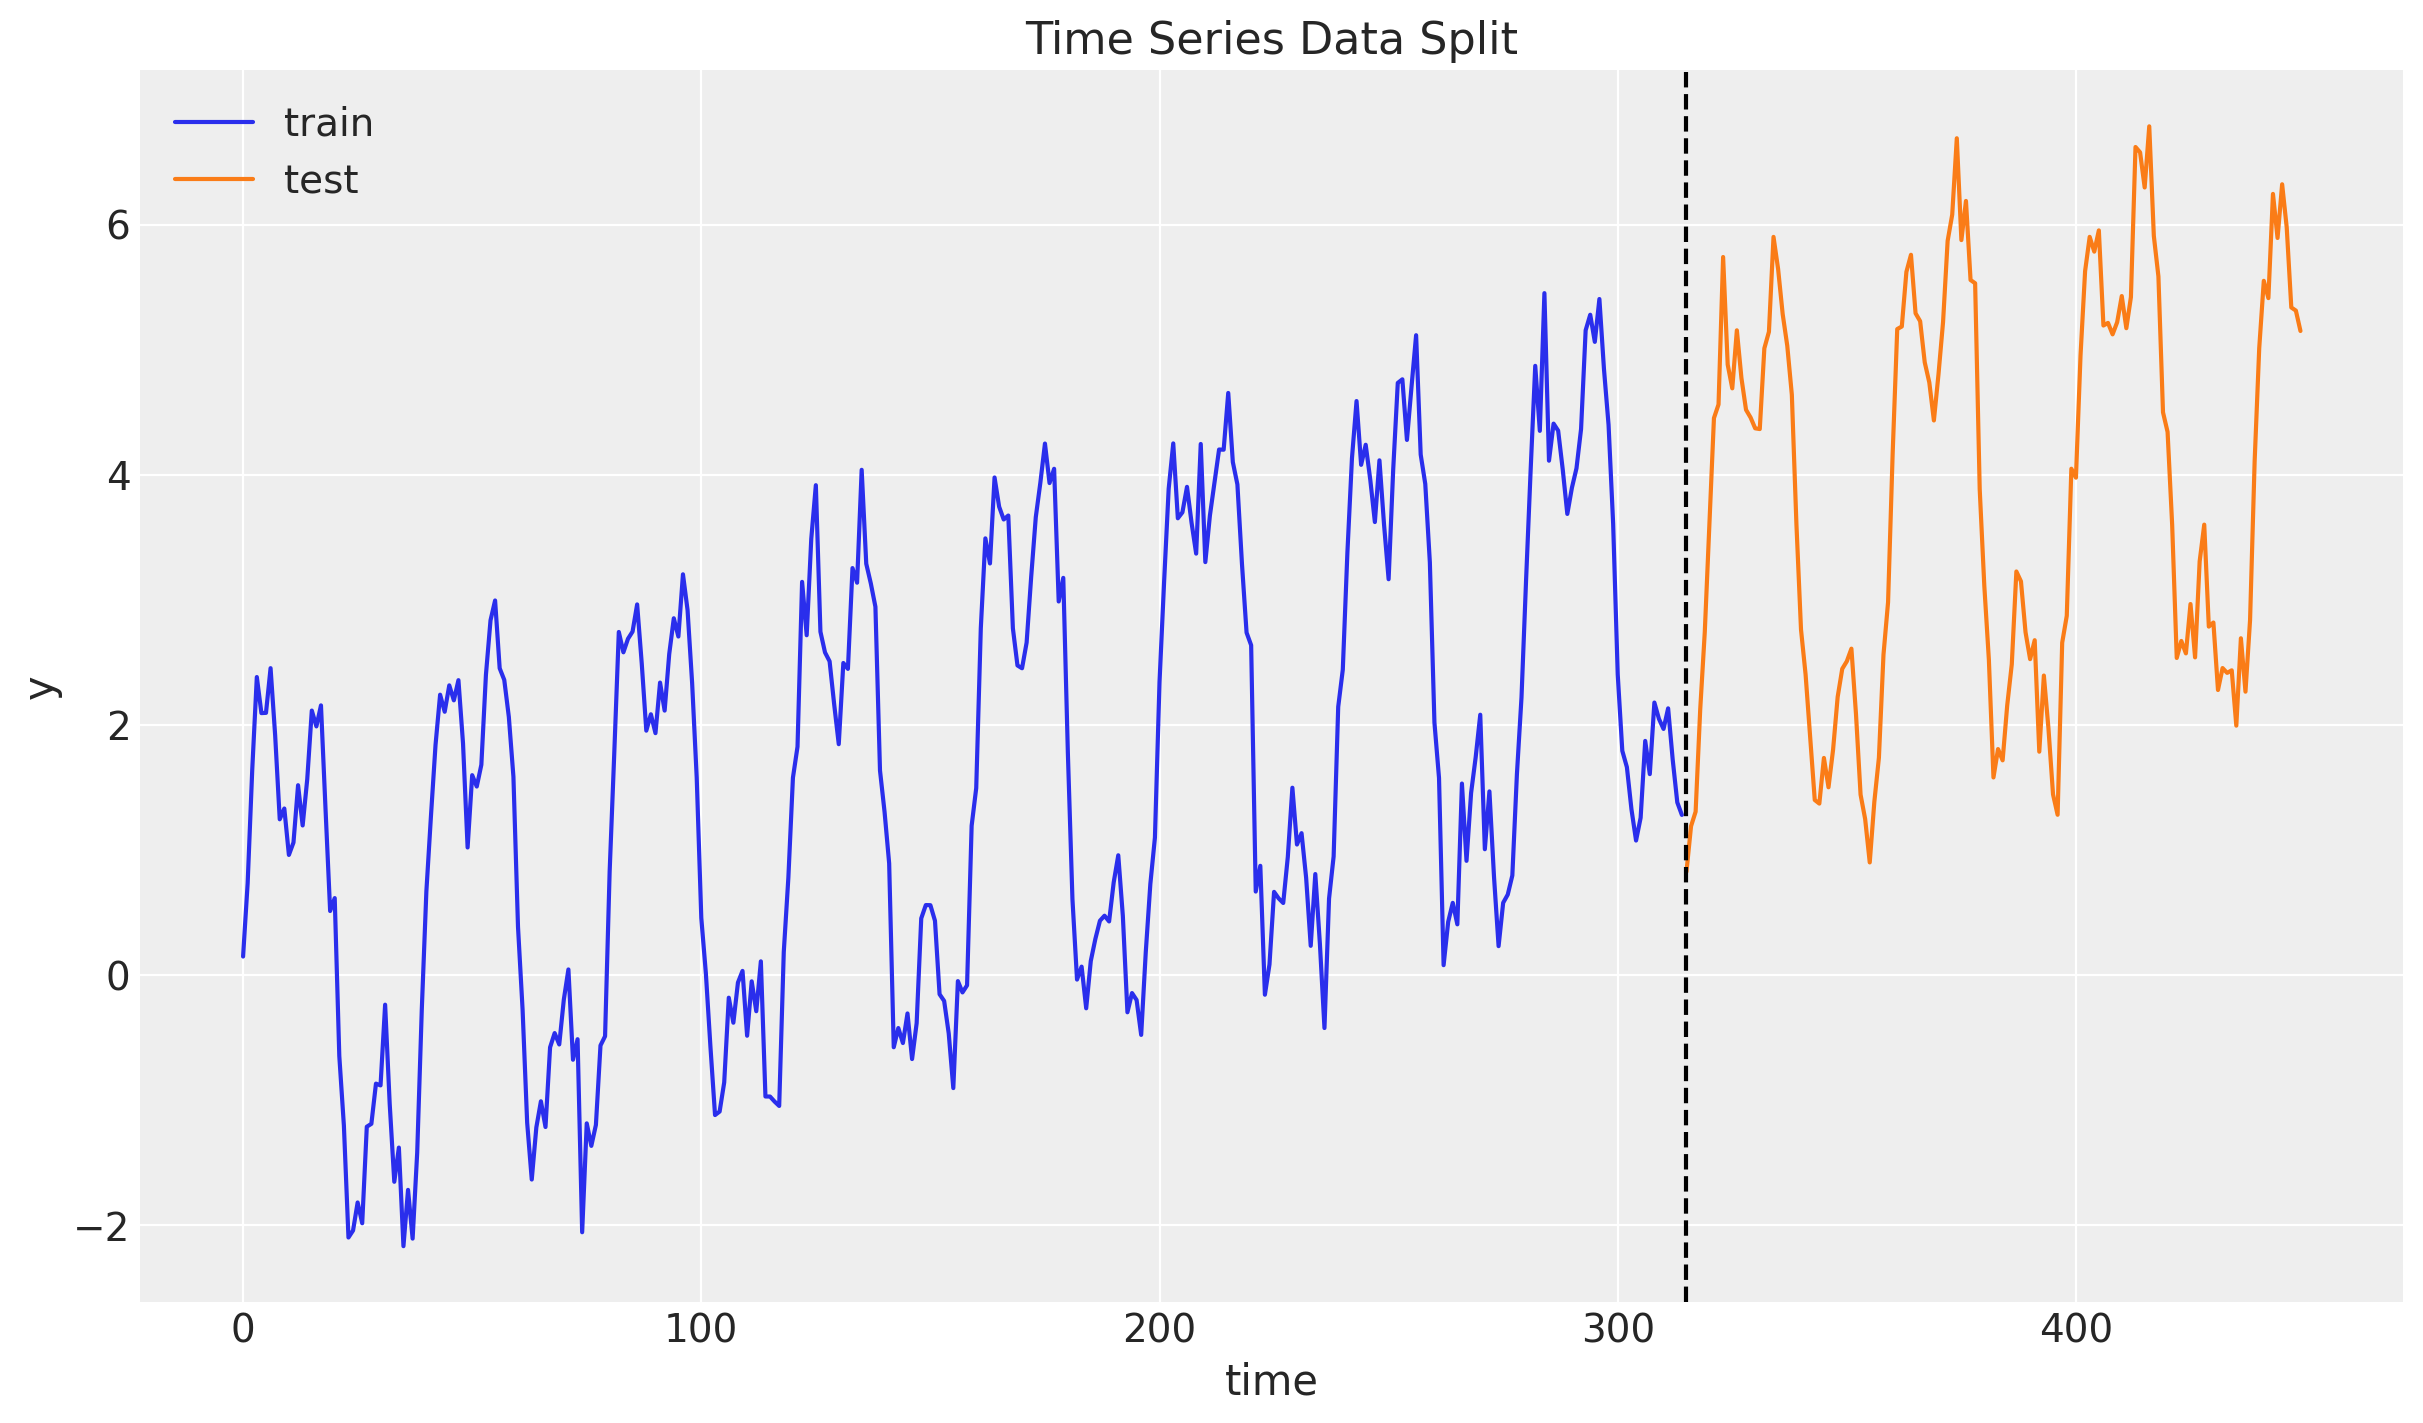

In [3]:
n = y.size

prop_train = 0.7
n_train = round(prop_train * n)

y_train = y[:n_train]
y_test = y[n_train:]

fig, ax = plt.subplots()
ax.plot(range(n_train), y_train, color="C0", label="train")
ax.plot(range(n_train, n), y_test, color="C1", label="test")
ax.axvline(x=n_train, c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Time Series Data Split")

## Level Model

### Model Specification

In [4]:
def level_model(y: ArrayImpl, future: int = 0):
    t_max = y.shape[0]
    level_smoothing = numpyro.sample("level_smoothing", dist.Beta(1, 1))
    noise = numpyro.sample("noise", dist.HalfNormal(1))
    level_init = numpyro.sample("level_init", dist.Normal(0, 1))

    def transition_fn(carry, t):
        previous_level = carry
        level = jnp.where(
            t < t_max,
            level_smoothing * y[t] + (1 - level_smoothing) * previous_level,
            previous_level,
        )

        mu = previous_level
        pred = numpyro.sample("pred", dist.Normal(mu, noise))

        return level, pred

    with numpyro.handlers.condition(data={"pred": y}):
        _, preds = scan(
            transition_fn,
            level_init,
            jnp.arange(t_max + future),
        )

    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:])

### Inference

In [5]:
level_nuts_kernel = NUTS(model=level_model)
level_mcmc = MCMC(
    sampler=level_nuts_kernel, num_samples=2_000, num_warmup=2_000, num_chains=4
)
rng_key, rng_subkey = random.split(key=rng_key)
level_mcmc.run(rng_subkey, y_train)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Level Model Trace')

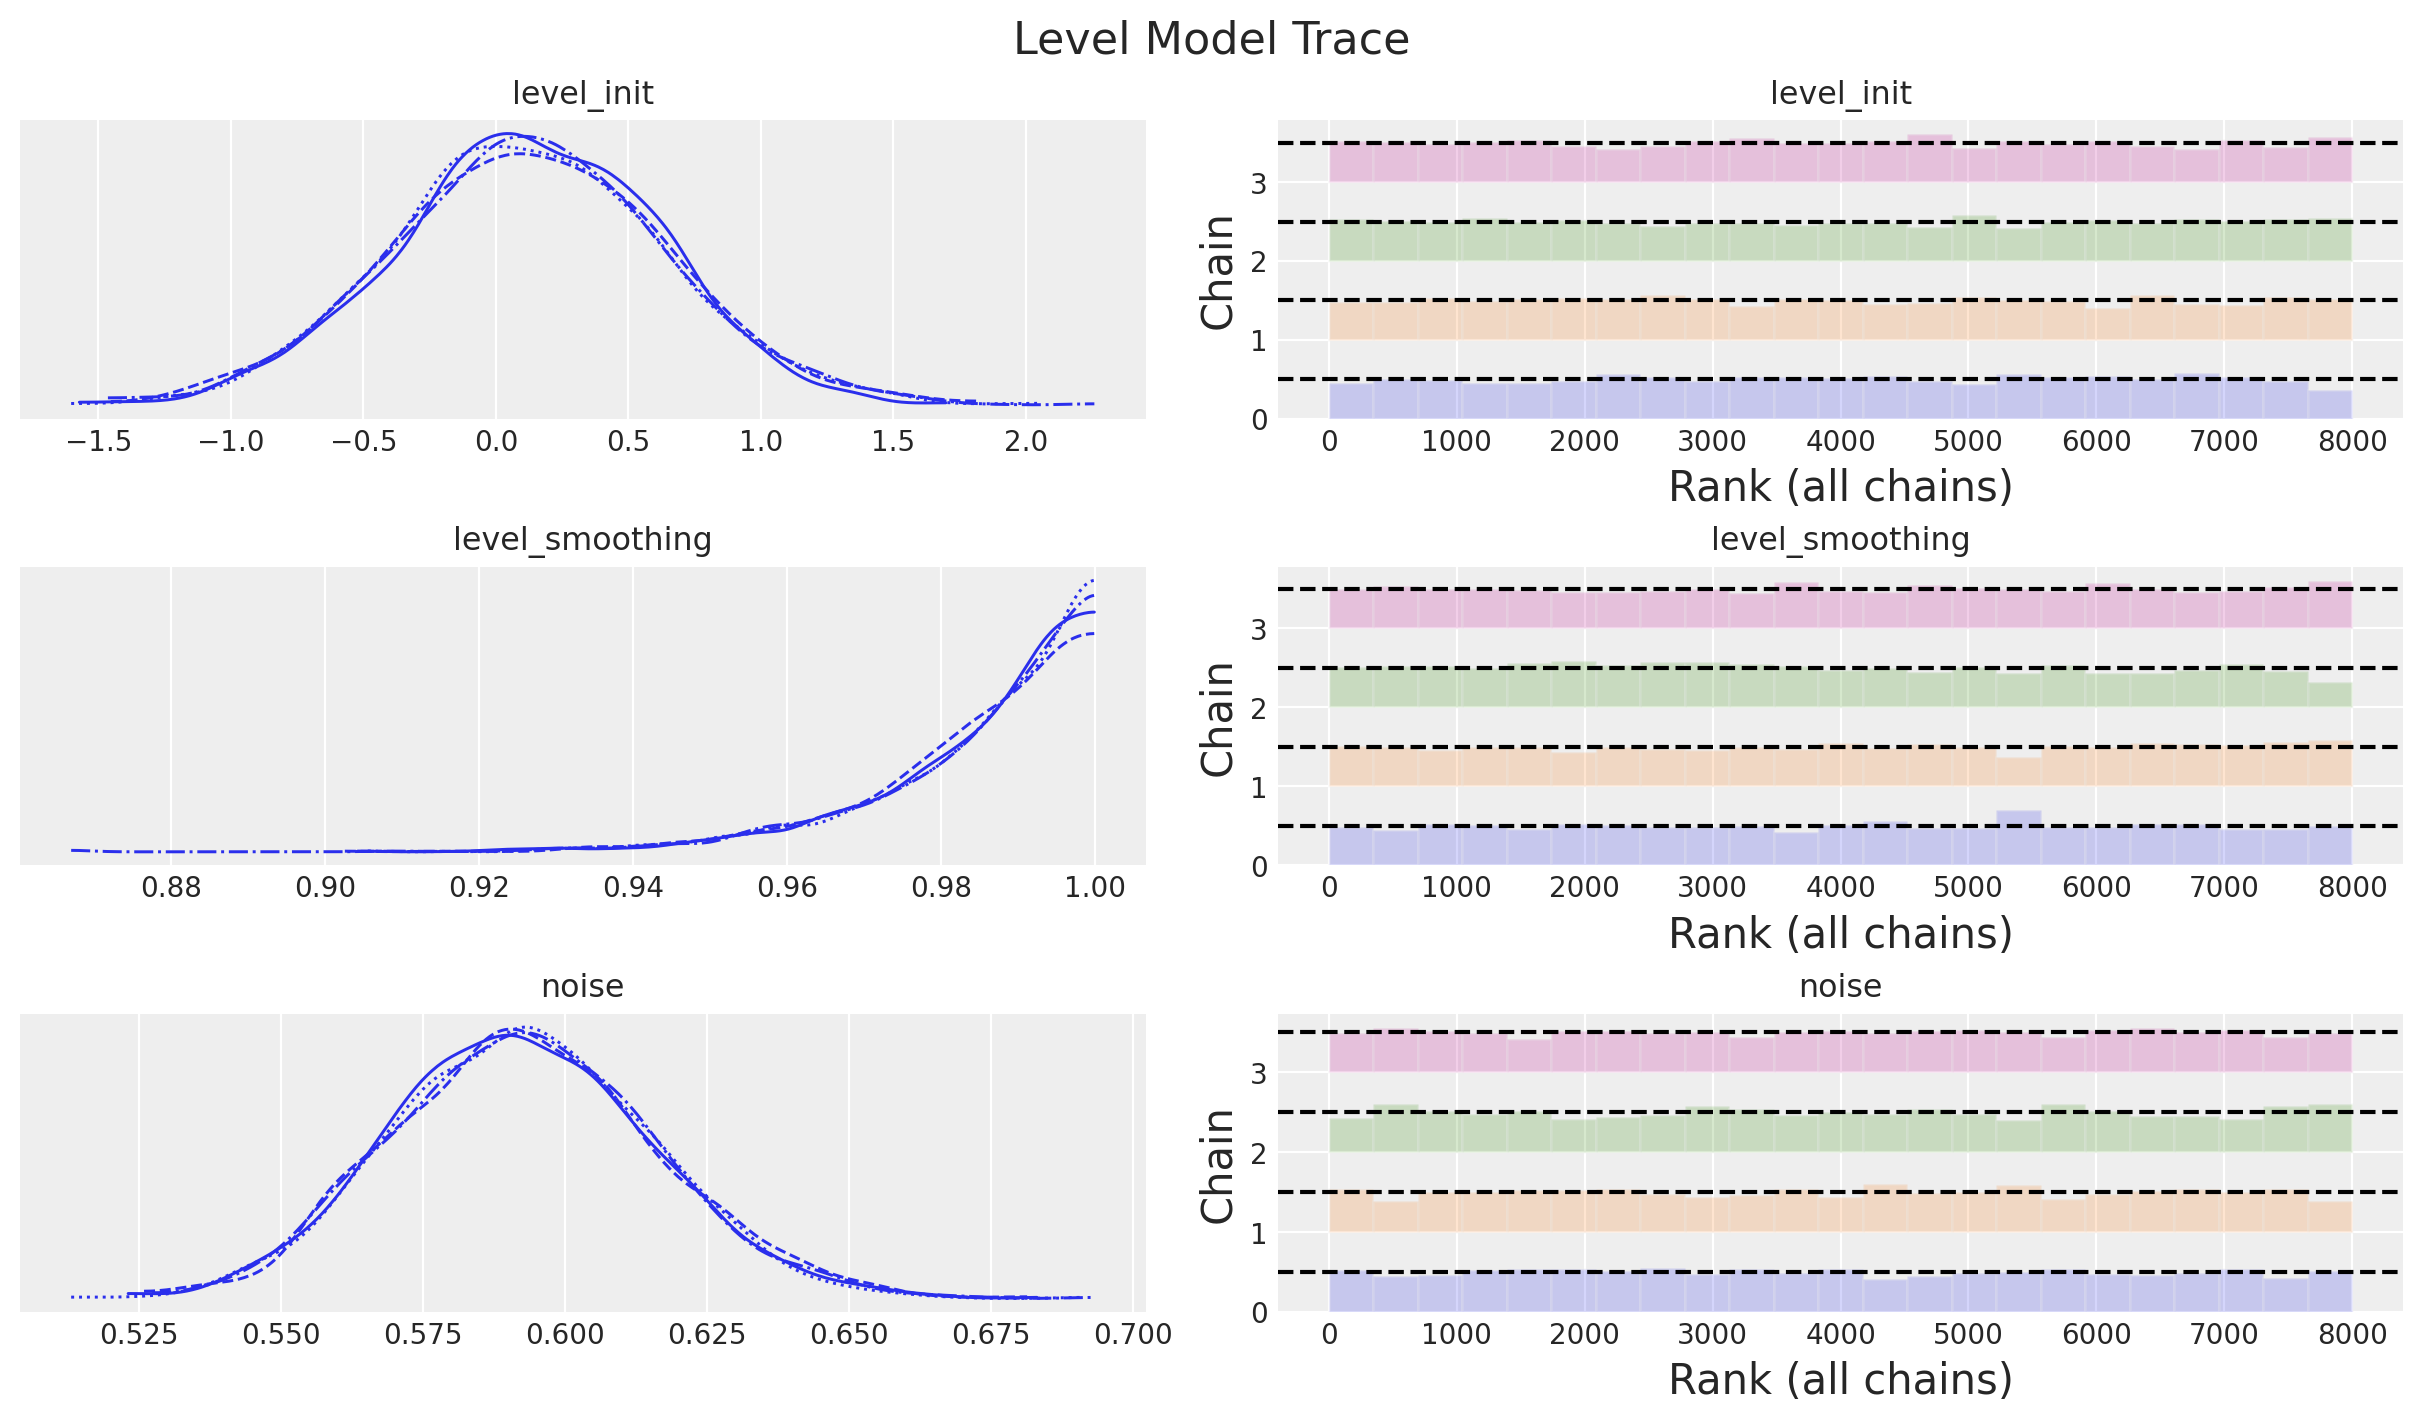

In [6]:
level_idata = az.from_numpyro(posterior=level_mcmc)

axes = az.plot_trace(
    data=level_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Level Model Trace", fontsize=16)

### Predictions

In [7]:
level_predictive = Predictive(
    model=level_model,
    posterior_samples=level_mcmc.get_samples(),
    return_sites=["y_forecast"],
)

rng_key, rng_subkey = random.split(key=rng_key)
level_forecast = level_predictive(rng_subkey, y_train, future=y_test.size)

In [8]:
level_posterior_predictive = az.from_numpyro(
    posterior_predictive=level_forecast,
    coords={"t": range(n_train, n)},
    dims={"y_forecast": ["t"]},
)

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Level Model Forecast')]

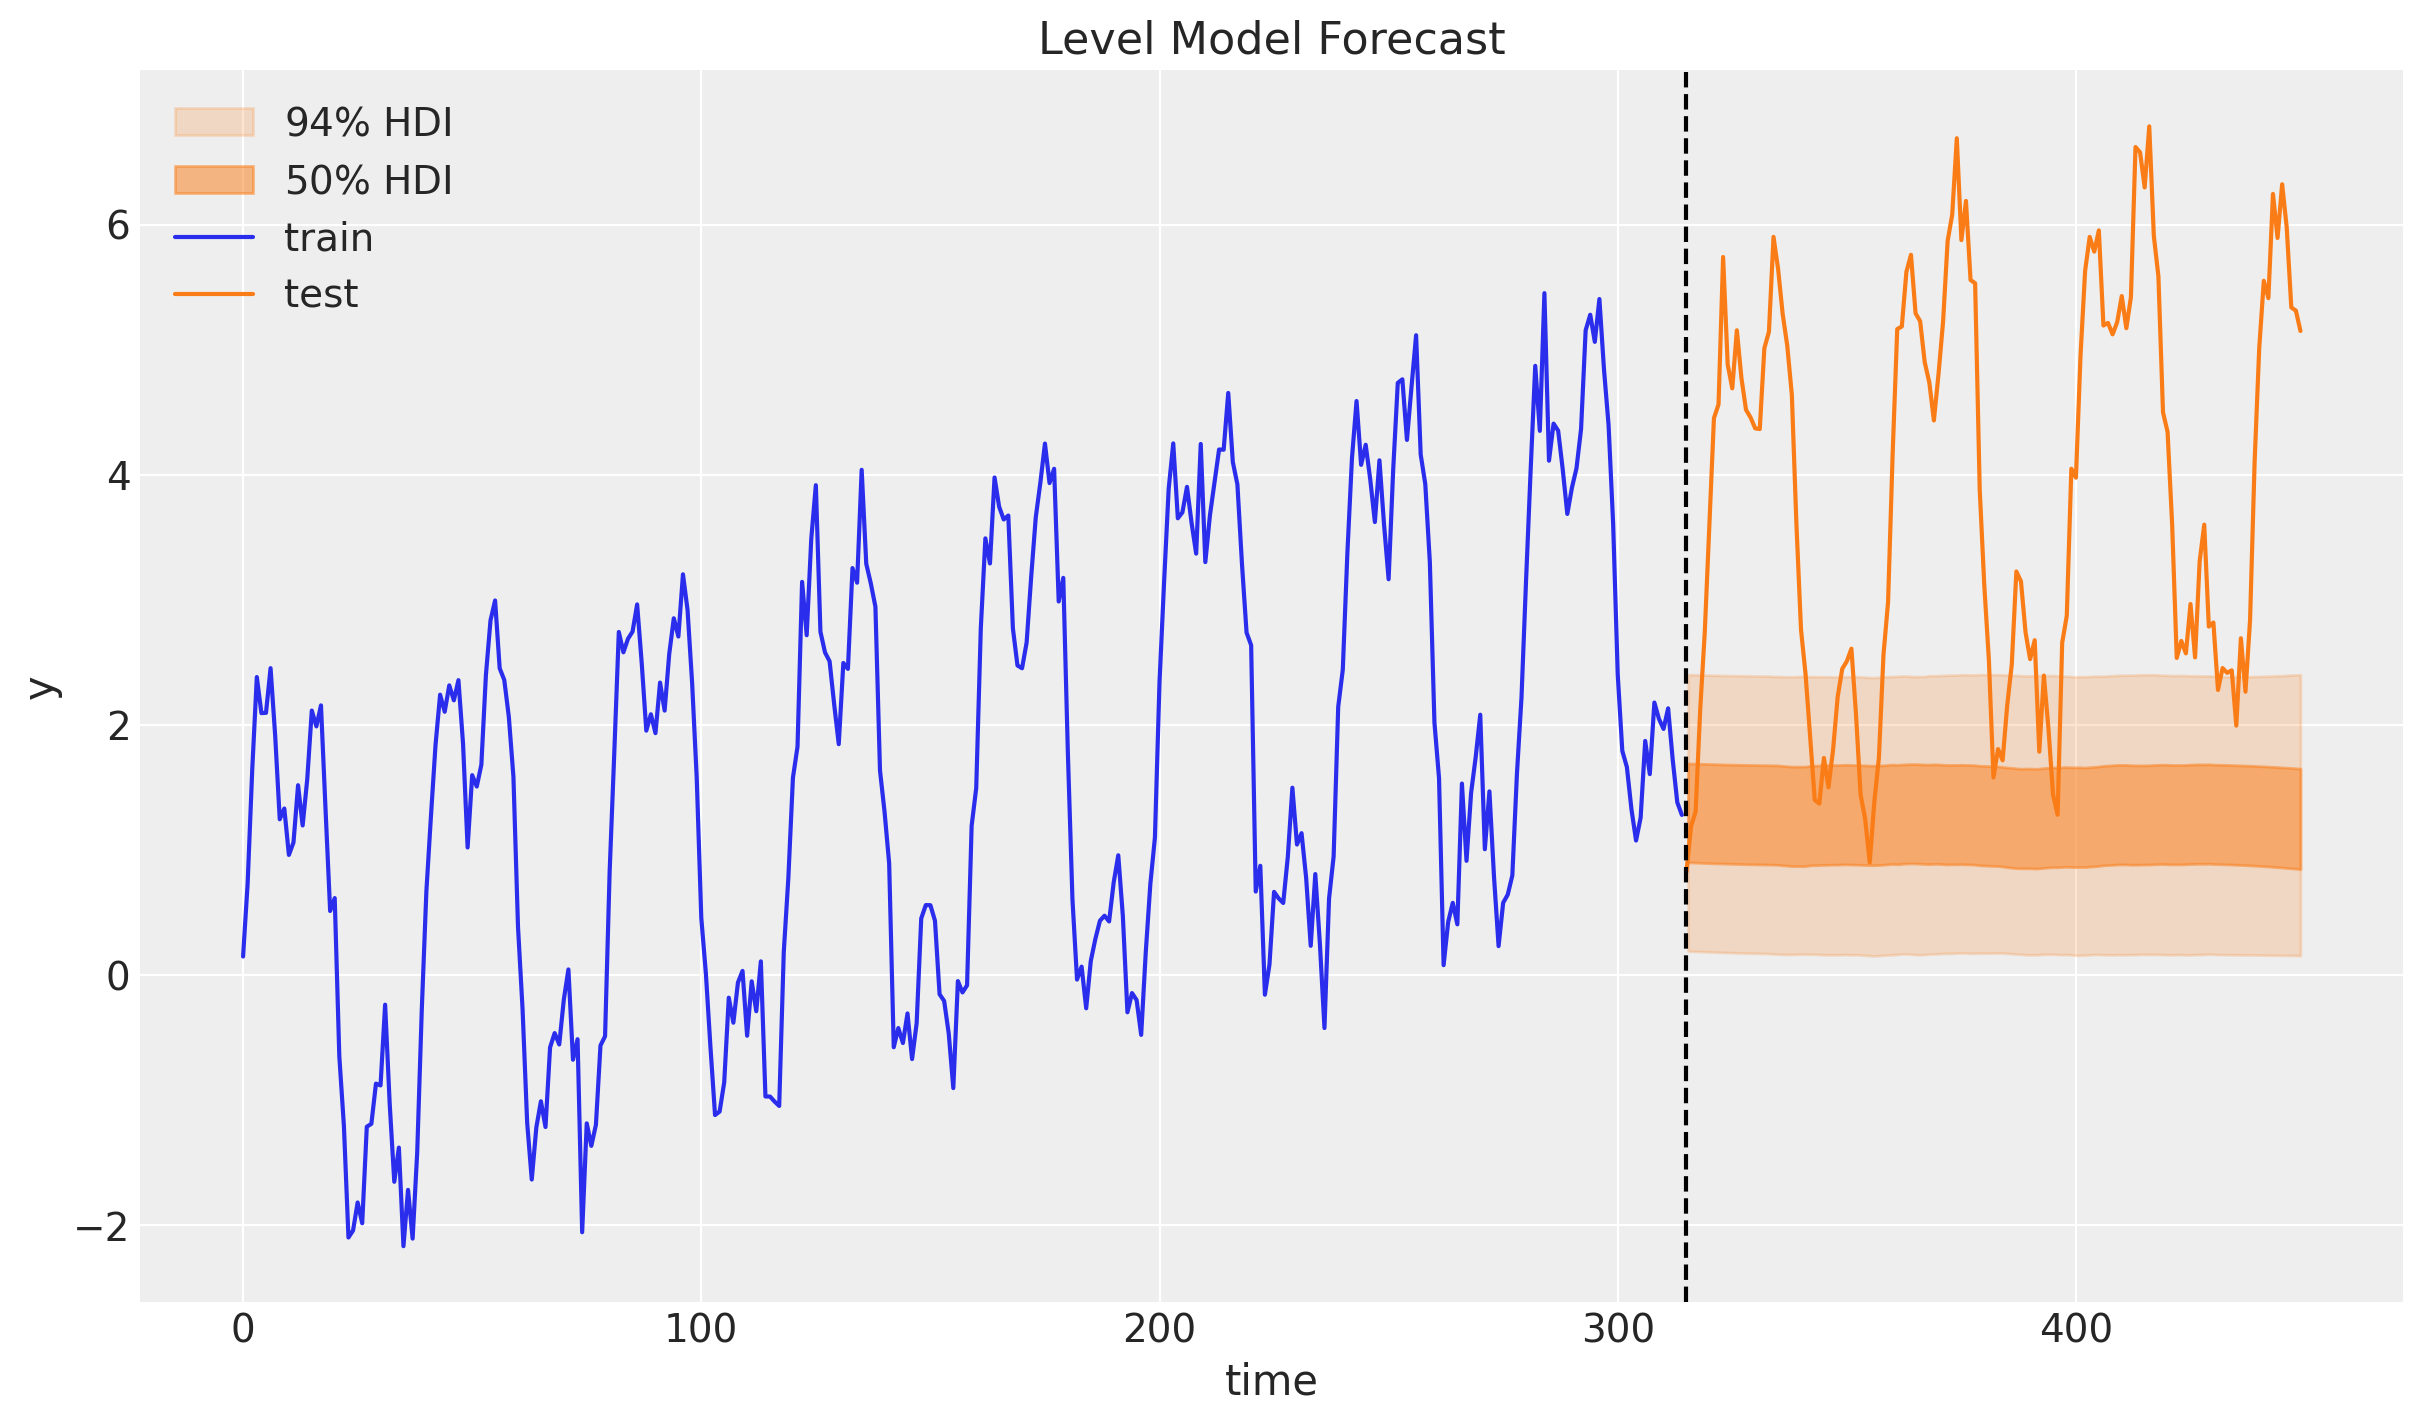

In [11]:
fig, ax = plt.subplots()
az.plot_hdi(
    range(n_train, n),
    level_posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    range(n_train, n),
    level_posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.50,
    color="C1",
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
    ax=ax,
)
ax.plot(range(n_train), y_train, color="C0", label="train")
ax.plot(range(n_train, n), y_test, color="C1", label="test")
ax.axvline(x=n_train, c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Level Model Forecast")